# Scan Area Detector v. Motor

<h3>Goals</h3>

- [x] **Use EPICS motor(s):**
  - [x] Record current value (readback)
  - [x] Record commanded value (setpoint)
- [x] **Use EPICS area detector:**
  - [x] For each image
    - [x] Write image to HDF5 file
    - [x] Measure total counts in image
    - [x] Measure maximum counts in image
    - [x] Note the image's "unique ID"
- [x] **Step scan motor and collect $n$ image frame(s) at each step:**
  - [x] Plan: count, just collect image(s)
  - [x] Plan: scan with one motor
  - [x] Plan: scan with two motors
  - [x] Plan: grid_scan with two motors
- [x] **Collect data in a SPEC data file.**

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory, so we add that to the search path before importing it.

In [1]:
import pathlib, sys

sys.path.append(str(pathlib.Path().home() / "bluesky"))
from instrument.collection import *

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Fri-18:38:11 - ############################################################ startup
I Fri-18:38:11 - logging started
I Fri-18:38:11 - logging level = 10
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/session_logs.py
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/collection.py
I Fri-18:38:11 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2024_2


Exception reporting mode: Minimal


I Fri-18:38:11 - xmode exception level: 'Minimal'
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Fri-18:38:11 - #### Bluesky Framework ####
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Fri-18:38:11 - RunEngine metadata saved in directory: /home/prjemian/.config/Bluesky_RunEngine_md
I Fri-18:38:11 - using databroker catalog 'training'
I Fri-18:38:11 - using ophyd control layer: pyepics
I Fri-18:38:11 - Using EPICS PV gp:gp:int20 for scan_id
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Fri-18:38:11 - #### Devices ####
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Fri-18:38:11 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Fri-18:38:18 - /home/prjemian/bluesky/instrument/devices/fourc_diffractometer.p

- **Create a custom area detector class** with our own IOC prefix, add ROI and STATS plugins, and connect with local directories:

In [2]:
from apstools.devices import SingleTrigger_V34
from ophyd.areadetector import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector.plugins import ImagePlugin_V34
from ophyd.areadetector.plugins import PvaPlugin_V34
from ophyd.areadetector.plugins import ROIPlugin_V34
from ophyd.areadetector.plugins import StatsPlugin_V34
import hdf5plugin  # needed to read LZ4-compressed image from HDF5 file

from instrument.devices.area_detector import MyHDF5Plugin
from instrument.devices.area_detector import SimDetectorCam_V34

# for my IOC, these parameters apply:
AD_IOC = "kad:"
FILE_BASE_IOC = "/tmp/"
FILE_BASE_BLUESKY = "/mnt/iockad/tmp/"

class SimDetector_V34(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_V34, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=FILE_BASE_IOC,
        read_path_template=FILE_BASE_BLUESKY,
    )
    image = ADComponent(ImagePlugin_V34, "image1:")
    pva = ADComponent(PvaPlugin_V34, "Pva1:")
    roi1 = ADComponent(ROIPlugin_V34, "ROI1:")
    stats1 = ADComponent(StatsPlugin_V34, "Stats1:")

simdet = SimDetector_V34(AD_IOC, name="simdet")

## Setup & connect with EPICS

Search the ophyd object registry (`oregistry`) for the detector and motors. Verify that each is connected to EPICS.

In [3]:
for nm in "simdet m1 m2".split():
    obj = oregistry.find(nm)
    print(f"{obj.connected=!r} {nm!r}")

obj.connected=True 'simdet'
obj.connected=True 'm1'
obj.connected=True 'm2'


**Configure the area detector** to:

- Collect $n$ image frame(s) for each press of the *Acquire* button.
- Save image(s) to HDF5.
- Record total counts in the image.
- Record maximum counts in the image.
- Record the unique ID of the image.

In [4]:
def ad_setup(det):
    det.wait_for_connection(timeout=3)
    det.roi1.nd_array_port.put("SIM1")
    det.stats1.nd_array_port.put("ROI1")
    det.missing_plugins()

    det.cam.stage_sigs["num_images"] = 3

    det.hdf1.kind = "hinted"
    det.hdf1.create_directory.put(-5)
    det.hdf1.stage_sigs["compression"] = "LZ4"

    det.stats1.kind = "hinted"
    det.stats1.max_value.kind = "hinted"
    det.stats1.total.kind = "hinted"
    det.stats1.unique_id.kind = "hinted"

    det.cam.stage_sigs["wait_for_plugins"] = "Yes"
    det.hdf1.stage_sigs["blocking_callbacks"] = "No"
    det.image.stage_sigs["blocking_callbacks"] = "No"

ad_setup(simdet)

## Diagnostics (optional)

These steps are optional.

Show the data from area detector `simdet`.
This is the data collected by the `RE` during a run..

In [5]:
simdet.read()

OrderedDict([('simdet_stats1_unique_id',
              {'value': 152753, 'timestamp': 1718396497.409682}),
             ('simdet_stats1_max_value',
              {'value': 163.0, 'timestamp': 1718396497.409703}),
             ('simdet_stats1_total',
              {'value': 11535831.0, 'timestamp': 1718408302.7033188})])

- **Show how** `simdet` is configured to collect $n$ frames per point.

In [6]:
print("Image frames per point:", simdet.cam.stage_sigs["num_images"])

Image frames per point: 3


- **Show the staging configuration** for `simdet`.

In [7]:
from pprint import pprint

pprint({"simdet": simdet.stage_sigs})
pprint({"simdet.cam": simdet.cam.stage_sigs})
pprint({"simdet.hdf1": simdet.hdf1.stage_sigs})
pprint({"simdet.roi1": simdet.roi1.stage_sigs})
pprint({"simdet.stats1": simdet.stats1.stage_sigs})

{'simdet': OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])}
{'simdet.cam': OrderedDict([('num_images', 3), ('wait_for_plugins', 'Yes')])}
{'simdet.hdf1': OrderedDict([('enable', 1),
                             ('blocking_callbacks', 'No'),
                             ('parent.cam.array_callbacks', 1),
                             ('create_directory', -3),
                             ('auto_increment', 'Yes'),
                             ('array_counter', 0),
                             ('auto_save', 'Yes'),
                             ('num_capture', 0),
                             ('file_template', '%s%s_%6.6d.h5'),
                             ('file_write_mode', 'Stream'),
                             ('capture', 1),
                             ('compression', 'LZ4')])}
{'simdet.roi1': OrderedDict([('enable', 1),
                             ('blocking_callbacks', 'Yes'),
                             ('parent.cam.array_callbacks', 1)])}
{'simdet.stats1': OrderedDict

- **Show how the area detector ports are connected** in a diagram.

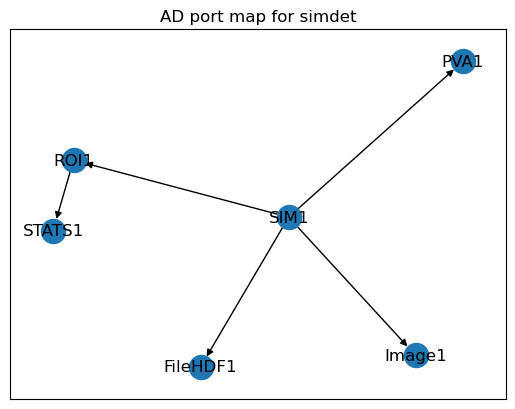

In [8]:
simdet.visualize_asyn_digraph()

### Read the Stats plugin signals

- The plan below reads the signals from `simdet.stats1` multiple times. Since `simdet` itself is not included in the list of detectors, it will not be triggered (and thus will not produce new images). One can notice that the `unique_id` does not change. For clarity, the command is split into multiple lines.



Transient Scan ID: 87     Time: 2024-06-14 18:38:23
Persistent Unique Scan ID: '24737a37-74a2-4b19-b06f-3df3902f0ea0'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+-------------------------+-------------------------+---------------------+
|         1 | 18:38:24.1 |                  152753 |                     163 |            11535831 |
|         2 | 18:38:24.5 |                  152753 |                     163 |            11535831 |
|         3 | 18:38:24.9 |                  152753 |                     163 |            11535831 |
|         4 | 18:38:25.3 |                  152753 |                     163 |            11535831 |
|         5 | 18:38:25.6 |                  152753 |                     163 |            11535831 |
+-----------+------------+-------------------------+-------------------------+---------------------+
generator count ['24737a37'] (scan nu

('24737a37-74a2-4b19-b06f-3df3902f0ea0',)

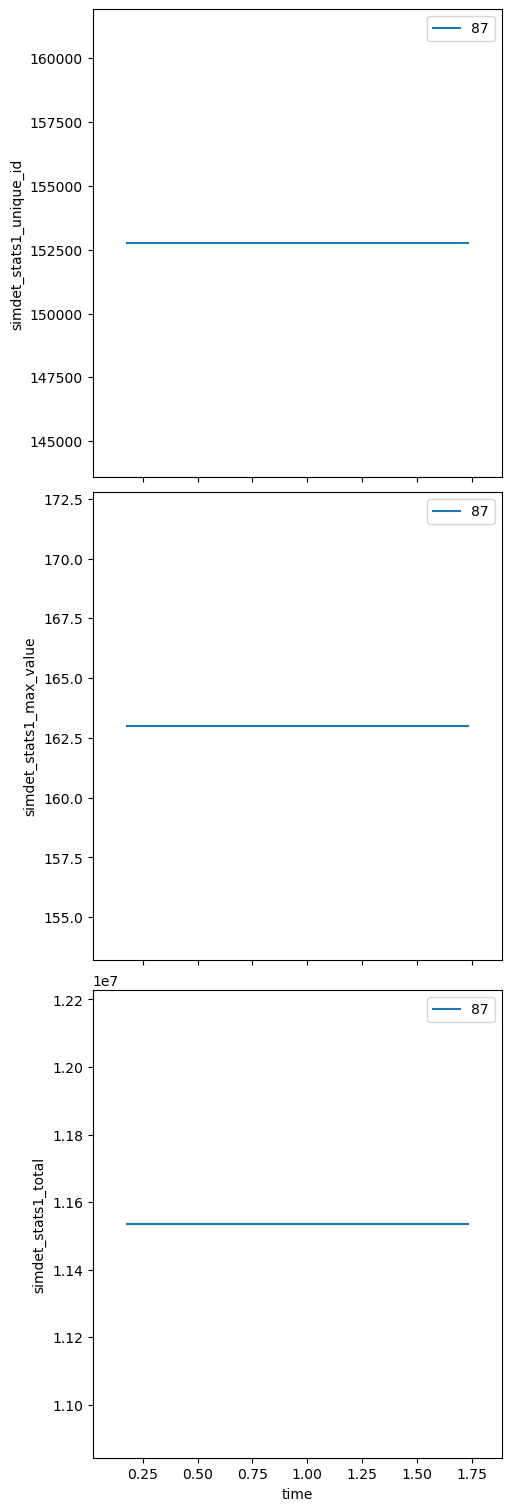

In [9]:
RE(
    bp.count(
        [
            simdet.stats1.unique_id, 
            simdet.stats1.total, 
            simdet.stats1.max_value
            ], 
        num=5
        )
    )

In [10]:
# Assume our run is the most recent one in the catalog
run = cat[-1]
print(f"{run=!r}")

# Read the primary data from the most recent run
dataset = run.primary.read()
dataset

run=<BlueskyRun uid='24737a37-74a2-4b19-b06f-3df3902f0ea0'>


/home/prjemian/.conda/envs/bluesky_2024_2/lib/python3.11/site-packages/databroker/intake_xarray_core/base.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 160B
Dimensions:                  (time: 5)
Coordinates:
  * time                     (time) float64 40B 1.718e+09 ... 1.718e+09
Data variables:
    simdet_stats1_unique_id  (time) int64 40B 152753 152753 152753 152753 152753
    simdet_stats1_max_value  (time) float64 40B 163.0 163.0 163.0 163.0 163.0
    simdet_stats1_total      (time) float64 40B 1.154e+07 ... 1.154e+07

## Take image(s) with the `bp.count` plan

Collect 5 sets of images (3-frames each as configured above).



Transient Scan ID: 88     Time: 2024-06-14 18:38:27
Persistent Unique Scan ID: '3150f83f-9d10-4d9e-b9f5-659872cdfaa0'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+-------------------------+-------------------------+---------------------+
|         1 | 18:38:27.9 |                  152756 |                     162 |            11536441 |
|         2 | 18:38:28.3 |                  152759 |                     159 |            11375680 |
|         3 | 18:38:28.8 |                  152762 |                     166 |            11816159 |
|         4 | 18:38:29.2 |                  152765 |                     160 |            11392858 |
|         5 | 18:38:29.6 |                  152768 |                     161 |            11485969 |
+-----------+------------+-------------------------+-------------------------+---------------------+
generator count ['3150f83f'] (scan nu

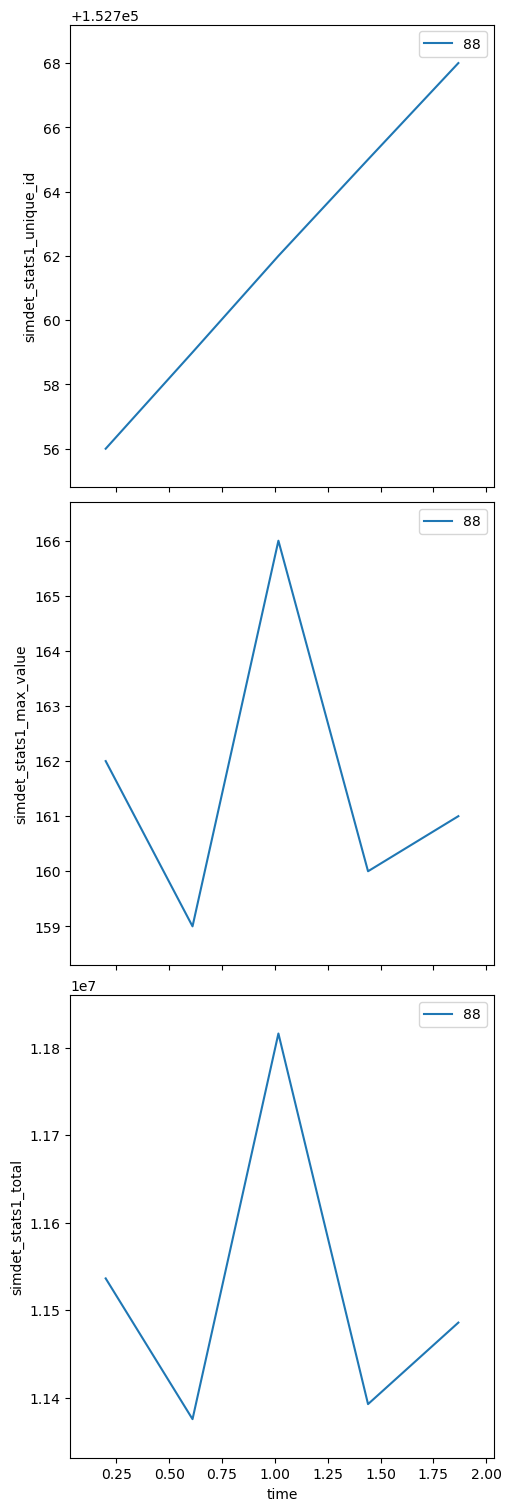

In [11]:
uids = RE(bp.count([simdet], num=5))
print(f"uids=!r")

### Visualize the collected data

Let's examine the data from the most recent run in the catalog:

In [12]:
# Get the dataset from the most recent run
dataset = cat[uids[-1]].primary.read()

#  Extract the image data
image_data = dataset["simdet_image"]

# Print the shape of the image data
print(f"{image_data.shape=!r}")

# Display the dataset
dataset

image_data.shape=(5, 3, 1024, 1024)


<xarray.Dataset> Size: 16MB
Dimensions:                  (time: 5, dim_0: 3, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time                     (time) float64 40B 1.718e+09 ... 1.718e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    simdet_image             (time, dim_0, dim_1, dim_2) uint8 16MB 10 8 ... 10
    simdet_stats1_unique_id  (time) int64 40B 152756 152759 152762 152765 152768
    simdet_stats1_max_value  (time) float64 40B 162.0 159.0 166.0 160.0 161.0
    simdet_stats1_total      (time) float64 40B 1.154e+07 ... 1.149e+07

- **Display the first image frame** from the first *point*.

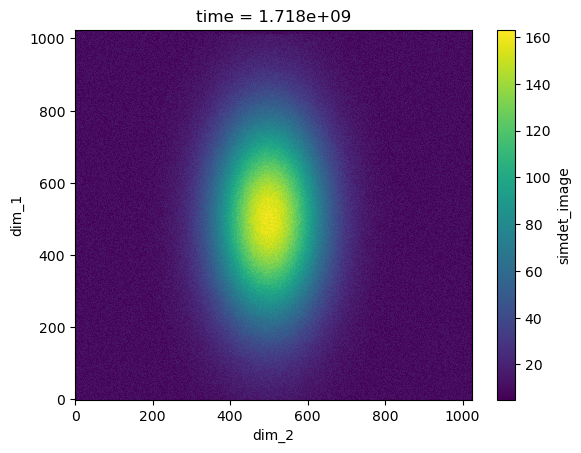

In [13]:
image_data[0][0].plot.pcolormesh()  # Plot the first frame.

### About the HDF5 image file

Information about the HDF5 file is saved as a `resource` document in the catalog.  This command shows the content of that document.

In [14]:
run = cat[uids[-1]]
resources = run.primary._resources
resources

[Resource({'path_semantics': 'posix',
 'resource_kwargs': {'frame_per_point': 3},
 'resource_path': 'mnt/iockad/tmp/eef6bc7c-bc78-44ce-80f1_000000.h5',
 'root': '/',
 'run_start': '3150f83f-9d10-4d9e-b9f5-659872cdfaa0',
 'spec': 'AD_HDF5',
 'uid': '878fed37-1308-4444-aa04-4d722553b9a4'})]

**Note** this is a Python `list`.
The file name, as the catalog will find its image contents, is reconstructed:

In [15]:
resources[0]["root"] + resources[0]["resource_path"]

'/mnt/iockad/tmp/eef6bc7c-bc78-44ce-80f1_000000.h5'

**Show that this file is recognized** on the file system available to Bluesky.

In [16]:
from pathlib import Path

image_file = Path(resources[0]["root"] + resources[0]["resource_path"])
image_file.exists()

True

## The (1-D) `bp.scan()` plan with one motor

Step scan a motor (m1) and measure 3 (as configured above) images at each step.  Also record total counts and the maximum counts value for each step.

In the interest of brevity here, further graphical data visualization will be turned off.  Refer to the section above for the visualization steps.  They are identical for each type of scan.

In [17]:
bec.disable_plots()

**Run** the scan.

In [18]:
uids = RE(bp.scan([simdet], m1, -1, 1, 5))
dataset = cat[uids[-1]].primary.read()
image_data = dataset["simdet_image"]
print(f"{image_data.shape=!r}")
dataset



Transient Scan ID: 89     Time: 2024-06-14 18:38:32
Persistent Unique Scan ID: 'bcf1e286-325e-4808-af42-c63d8ef4fed8'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 18:38:34.7 |    -1.0000 |                  152771 |                     164 |            11698714 |
|         2 | 18:38:35.5 |    -0.5000 |                  152774 |                     165 |            11763108 |
|         3 | 18:38:36.3 |     0.0000 |                  152777 |                     163 |            11659032 |
|         4 | 18:38:37.1 |     0.5000 |                  152780 |                     164 |            11658545 |
|         5 | 18:38:37.9 |     1.0000 |                  152783 |                     160 |            11389070 |
+-----------+------------+--------

<xarray.Dataset> Size: 16MB
Dimensions:                  (time: 5, dim_0: 3, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time                     (time) float64 40B 1.718e+09 ... 1.718e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    simdet_image             (time, dim_0, dim_1, dim_2) uint8 16MB 11 7 ... 10
    simdet_stats1_unique_id  (time) int64 40B 152771 152774 152777 152780 152783
    simdet_stats1_max_value  (time) float64 40B 164.0 165.0 163.0 164.0 160.0
    simdet_stats1_total      (time) float64 40B 1.17e+07 1.176e+07 ... 1.139e+07
    m1                       (time) float64 40B -1.0 -0.5 0.0 0.5 1.0
    m1_user_setpoint         (time) float64 40B -1.0 -0.5 0.0 0.5 1.0

## The (1-D) `bp.scan()` plan with two motors

Step scan two motors together (m1 & m2) and measure 3 (as configured above) images at each step.  Also record total counts and the maximum counts value for each step.

For clarity, the `scan` arguments are split into multiple lines.

In [19]:
uids = RE(
    bp.scan(
        [simdet],
        m1, -1, 1,
        m2, 4, 1.5,
        5,
    )
)
print(f"uids=!r")

dataset = cat[uids[-1]].primary.read()
image_data = dataset["simdet_image"]
print(f"{image_data.shape=!r}")

dataset



Transient Scan ID: 90     Time: 2024-06-14 18:38:38
Persistent Unique Scan ID: 'ef338ace-f2be-437a-b838-d501bbbf7efd'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 |         m2 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 18:38:42.7 |    -1.0000 |     4.0000 |                  152786 |                     164 |            11688862 |
|         2 | 18:38:43.6 |    -0.5000 |     3.3750 |                  152789 |                     165 |            11741804 |
|         3 | 18:38:44.4 |     0.0000 |     2.7500 |                  152792 |                     164 |            11663410 |
|         4 | 18:38:45.4 |     0.5000 |     2.1250 |                  152795 |                     162 |            11537004 |
|         5 | 18:38:46.3 |     1.0000 |     1.5000 |     

<xarray.Dataset> Size: 16MB
Dimensions:                  (time: 5, dim_0: 3, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time                     (time) float64 40B 1.718e+09 ... 1.718e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    simdet_image             (time, dim_0, dim_1, dim_2) uint8 16MB 6 5 ... 6 12
    simdet_stats1_unique_id  (time) int64 40B 152786 152789 152792 152795 152798
    simdet_stats1_max_value  (time) float64 40B 164.0 165.0 164.0 162.0 160.0
    simdet_stats1_total      (time) float64 40B 1.169e+07 ... 1.139e+07
    m2                       (time) float64 40B 4.0 3.375 2.75 2.125 1.5
    m2_user_setpoint         (time) float64 40B 4.0 3.375 2.75 2.125 1.5
    m1                       (time) float64 40B -1.0 -0.5 0.0 0.5 1.0
    m1_user_setpoint         (time) float64 40B -1.0 -0.5 0.0 0.5 1.0

### Show the sequence of motor positions

The second motor of the `scan` (`m2`) is moved at the same time as the first motor (`m1`).  Here's a plot of readback of each motor from a two-motor `scan` plotted *v*. data point number:

![grid_scan motors v point number](../_static/scan_two_motors.png)

## The (2-D) `bp.grid_scan()` (mesh) plan

Step scan two motors (m1 & m2) and measure images at each step, as before.  Also record total counts and the maximum counts value for each step.

For clarity, the `grid_scan` arguments are split into multiple lines.

In [20]:
uids = RE(
    bp.grid_scan(
        [simdet], 
        m1, -1, 1, 5,
        m2, -0.5, 0.5, 4,
        snake_axes=True,
    )
)
print(f"uids=!r")

dataset = cat[uids[-1]].primary.read()
image_data = dataset["simdet_image"]
print(f"{image_data.shape=!r}")

dataset



Transient Scan ID: 91     Time: 2024-06-14 18:38:47
Persistent Unique Scan ID: '68da3698-bcfa-49b7-95f1-68732545077a'


device=MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']), exception=Data keys (field names) from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']) collide with those from MyEpicsMotor(prefix='gp:m2', name='m2', settle_time=0.0, timeout=None, read_attrs=['user_readback', 'user_setpoint'], configuration_attrs=['user_offset', 'user_offset_dir', 'velocity', 'acceleration', 'motor_egu']). The colliding keys are {'m2', 'm2_user_setpoint'}


New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|   seq_num |       time |         m1 |         m2 | simdet_stats1_unique_id | simdet_stats1_max_value | simdet_stats1_total |
+-----------+------------+------------+------------+-------------------------+-------------------------+---------------------+
|         1 | 18:38:49.6 |    -1.0000 |    -0.5000 |                  152801 |                     166 |            11823332 |
|         2 | 18:38:50.2 |    -1.0000 |    -0.1667 |                  152804 |                     166 |            11842544 |
|         3 | 18:38:50.8 |    -1.0000 |     0.1667 |                  152807 |                     166 |            11855439 |
|         4 | 18:38:51.4 |    -1.0000 |     0.5000 |                  152810 |                     162 |            11495078 |
|         5 | 18:38:52.2 |    -0.5000 |     0.5000 |     

<xarray.Dataset> Size: 63MB
Dimensions:                  (time: 20, dim_0: 3, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time                     (time) float64 160B 1.718e+09 ... 1.718e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    simdet_image             (time, dim_0, dim_1, dim_2) uint8 63MB 8 9 ... 7 12
    simdet_stats1_unique_id  (time) int64 160B 152801 152804 ... 152855 152858
    simdet_stats1_max_value  (time) float64 160B 166.0 166.0 ... 163.0 164.0
    simdet_stats1_total      (time) float64 160B 1.182e+07 ... 1.172e+07
    m2                       (time) float64 160B -0.5 -0.1667 ... 0.1667 0.5
    m2_user_setpoint         (time) float64 160B -0.5 -0.1667 ... 0.1667 0.5
    m1                       (time) float64 160B -1.0 -1.0 -1.0 ... 1.0 1.0 1.0
    m1_user_setpoint         (time) float64 160B -1.0 -1.0 -1.0 ... 1.0 1.0 1.0

### Show the sequence of motor positions

The second motor of the `grid_scan` (`m2`) is snaked.  It's direction changes with each subsequent increment of the first motor (`m1`).  Here's a plot of readback value of each motor from a `grid_scan` plotted *v*. data point number:

![grid_scan motors v time-of-day](../_static/grid_scan_snake.png)

## SPEC data file

All along, quietly in the background, the data has been saved both to a catalog
and to a SPEC data file.  Show the SPEC file.  The total counts, max counts, and
unique ID from all scans can be plotted from the SPEC file using PyMCA or NeXpy.

The image content is not stored in the SPEC file; images cannot be viewed from
the SPEC file.  

References to the images are save as comments.  See comment lines that match a search for

`resource {'spec': 'AD_HDF5'`

Here is an example:

```
#C Thu Jun 13 11:36:38 2024.  resource {'spec': 'AD_HDF5', 'root': '/', 'resource_path': 'mnt/iockad/tmp/d94f633b-12a7-4ff0-92af_000000.h5', 'resource_kwargs': {'frame_per_point': 3}, 'path_semantics': 'posix', 'uid': '5328206b-dd13-49f8-b108-17e0d867d470', 'run_start': 'e8c24278-656f-4c79-b3eb-d522310f7649'}
```

In [21]:
with open(specwriter.spec_filename) as f:
    print(f.read())

#F /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/20240614-183822.dat
#E 1718408302
#D Fri Jun 14 18:38:22 2024
#C Bluesky  user = prjemian  host = arf.jemian.org
#O0 dcm_m_theta  dcm_m_y  dcm_m_z  fourc_chi  fourc_omega  fourc_phi  fourc_tth  m1
#O1 m10  m11  m12  m13  m14  m15  m16  m2
#O2 m3  m4  m7  m8  m9  sixc_chi  sixc_delta  sixc_gamma
#O3 sixc_mu  sixc_omega  sixc_phi
#o0 dcm_m_theta  dcm_m_y  dcm_m_z  fourc_chi  fourc_omega  fourc_phi  fourc_tth  m1
#o1 m10  m11  m12  m13  m14  m15  m16  m2
#o2 m3  m4  m7  m8  m9  sixc_chi  sixc_delta  sixc_gamma
#o3 sixc_mu  sixc_omega  sixc_phi

#S 87  count(detectors=['simdet_stats1_unique_id', 'simdet_stats1_total', 'simdet_stats1_max_value'], num=5, delay=None)
#D Fri Jun 14 18:38:23 2024
#C Fri Jun 14 18:38:23 2024.  plan_type = generator
#C Fri Jun 14 18:38:23 2024.  uid = 24737a37-74a2-4b19-b06f-3df3902f0ea0
#MD uid = 24737a37-74a2-4b19-b06f-3df3902f0ea0
#MD beamline_id = Bluesky_training
#MD conda_prefi